In [1]:
import numpy as np
import sklearn.preprocessing as skl_pp
import sklearn.linear_model as skl_lm
import sklearn.model_selection as skl_ms

import matplotlib.pyplot as plt

# Linear Regression

I define $X=\mathcal E(\lambda_x)\cdot(2\mathcal B(0.5)-1)$, where the exponential part defines the absolute value of the variable, while the Bernoulli part defines its sign. Numpy apparently has no Bernoullian generator, so I use a Binomial with $n=1$.

I establish a linear relation adding a $r=\mathcal N(\mu_{res},\sigma_{res}^2)$, so $y = aX+r$. Indeed:
$$\mathbb E[y]=a\mathbb E[x]+\mathbb E[r]=a\cdot 0+1=1$$
$$\mathbb V[y]=\text{($X$ and $r$ indep.)}=
a^2\mathbb V[\mathcal E(\lambda_x)\cdot(2\mathcal B(0.5)-1)]+\mathbb V[r]=\\
a^2\left(\mathbb V[\mathcal E(\lambda_x)]\mathbb V[2\mathcal B(0.5)-1]+\mathbb V[\mathcal E(\lambda_x)]\mathbb E[2\mathcal B(0.5)-1]^2+\mathbb V[2\mathcal B(0.5)-1]\mathbb E[\mathcal E(\lambda_x)]^2\right)+\sigma_{res}^2=\\
a^2\left(\lambda_x^{-2}+\lambda^{-2}0+\lambda_x^{-2}\right)+\sigma_{res}^2=
2a^2\lambda_x^{-2}+\sigma_{res}^2=\frac121.5^2+4=5.125$$

Normalised data are obtained this way:
$$\frac{y-\mu_y}{\sigma_y}=\frac{a\sigma_X}{\sigma_y}\frac{X-\mu_x}{\sigma_X}+\frac{a\mu_x-\mu_y+r}{\sigma_y}$$
Note: $$\frac{a\sigma_X}{\sigma_y}=\frac{1.5}{\sqrt{2} \sqrt{5.125}}\approx0.468$$
Indeed, OLS regression should be able to capture this coefficient perfectly. Recall that $X$ and the residues are independent:
$$\min||y-X\beta||^2\Rightarrow \beta=\frac{\sum_i y_ix_i}{\sum_i x_i^2}=\frac{\sum_i (ax_i+r_i)x_i}{\sum_i x_i^2}=a+\frac{\sum_i r_ix_i}{\sum_i x_i^2}=a$$

In the following, $X\in \mathbb R^{N\times N}, y\in\mathbb R^N$.

0.47009362864377136


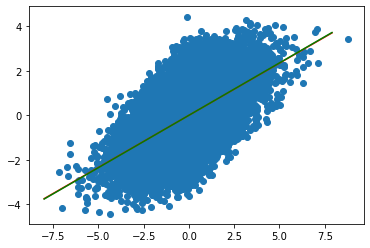

In [2]:
n_sample = 100000
lambda_x = 2
mu_res = 1
s2_res = 4
regression_param = 1.5

sign_x = 2*np.random.binomial(1, 0.5, n_sample)-1
X = (np.random.exponential(scale = 1/lambda_x, size = n_sample)*sign_x)
y = regression_param*X + np.random.normal(loc = mu_res, scale = np.sqrt(s2_res), size = n_sample)

scaler = skl_pp.StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 1))
y = scaler.fit_transform(y.reshape(-1, 1))

model = skl_lm.LinearRegression().fit(X,y)
print(model.coef_[0,0])

plt.scatter(X,y)
plt.plot(np.arange(-8,8,0.1),np.arange(-8,8,0.1)*0.468,color = 'red')
plt.plot(np.arange(-8,8,0.1),np.arange(-8,8,0.1)*model.coef_[0],color = 'green')
plt.show()

Now, we act as if our information is not perfect. We know that $y$ depends on $X$, but we think it depends on something else also. In example, a standard normal. The model can see the dependence on $X$, and just ignores the normal variables.

To understand this, take in consideration again the model $y=aX+r$, and suppose $y\sim \beta_1 X+ \beta_2 W$, where $X$ and $W$ are independent and standardised.
Being a multidimensional OLS regression, we know:
$$\beta = ( [X\, W]^T[X\, W] )^{-1}[X\, W]^T y\Rightarrow \beta_1 = \frac{\sum_i x_i y_i}{\sum_i x_i^2}=a,\quad \beta_2 = \frac{\sum_i w_i y_i}{\sum_i w_i^2}=a\frac{\sum_i x_i w_i}{\sum_i w_i^2}\approx0.$$

We start from a simpler model with respect to the previous case: $y=0.5X+r$, $r\sim \mathcal N(0,1)$, $X\sim \mathcal N(1,4)$.

In [3]:
n_sample = 10000
X = np.random.normal(loc = 1, scale = 4, size = n_sample).reshape(-1, 1)
y = 0.5*X[:,0] + np.random.normal(size = n_sample)

Y = np.array([ [X[i,0], np.random.normal()] for i in range(len(X)) ])

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_)

[ 0.50305419 -0.01189316]


Insert a direct dependence on $y$. The model captures it entirely and just drops $X$.

In [4]:
Y = np.array([ [X[i,0], y[i]] for i in range(len(X)) ])

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_)

[4.31081165e-16 1.00000000e+00]


Insert a partial dependence on $y$. The model takes again in consideration $X$ and reduces the coefficient of the artficial feature.

In [5]:
Y = np.array([ [X[i,0], y[i] if y[i] > 0 else np.random.normal() ] for i in range(len(X)) ])

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_)

[0.35089094 0.50532723]


If the second feature is a slightly disturbed $y$, the regressor trusts it more than $X$. This does not change running it multiple times.

In [6]:
Y = np.array([ [X[i,0], y[i]*np.random.normal(loc = 1, scale = 0.01) ] for i in range(len(X)) ])

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_)

[2.17557535e-04 9.99697044e-01]


Surprisingly, if the second feature is a disturbed first feature, the regressor may still favour it over the plain feature. Note that the behaviour is not consistent. Running it many times may give totally different results. Indeed, the sum of the coefficients is equal to the expected value.

In [7]:
Y = np.array([ [X[i,0], X[i,0]*np.random.normal(loc = 1, scale = 0.01) ] for i in range(len(X)) ])

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_)

[ 0.57574562 -0.07265968]


Think again of $Y = [ X\, W]$. Let's suppose $W=bX$, then 
$$[X\,W]^T[X\,W]=\left[\begin{matrix} 1& b \\ b& b^2\end{matrix}\right]$$
that is not invertible.

``LinearRegression().fit()`` can still do something. Possible explanation: the solver is based on scipy that is based on LAPACK, that uses SVD.

Check https://www2.math.uconn.edu/~leykekhman/courses/MATH3795/Lectures/Lecture_9_Linear_least_squares_SVD.pdf slide 11 for a SVD solution of OLS. The sum of the coefficients is still equal to the expected coefficient ..

In [8]:
Y = np.array([ [X[i,0], 0.25*X[i,0]] for i in range(len(X)) ])

y = 0.5*X[:,0]

model = skl_lm.LinearRegression().fit(Y,y)
print(model.coef_,0.25*model.coef_[1]+model.coef_[0])

[0.47058824 0.11764706] 0.4999999999999997


In [9]:
np.linalg.det(Y.transpose() @ Y)

0.0

In [10]:
U, S, V = np.linalg.svd(Y,full_matrices=False)
model_coeffs = U.transpose() @ y / S @ V
print('sanity check: ',np.any(U @ np.diag(S) @ V - Y < 1e-12))
print('OLS coefficients via SVD: ',model_coeffs,model_coeffs[0]+0.25*model_coeffs[1])

sanity check:  True
OLS coefficients via SVD:  [-1.75908254  9.03633017] 0.5000000000000009


Experiment: define $y=1.4X$, we heuristically (but wrongly) assume $y\sim 0.4 X$. Residuals will be equal to $X$, so they give us a hint of the mistake.

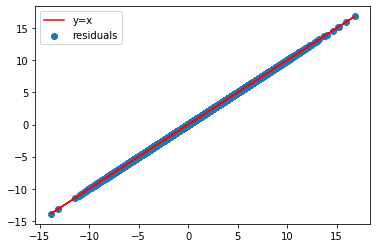

In [11]:
y = 1.4*X[:,0]

y_hat = 0.4*X[:,0]

plt.scatter(X,y-y_hat,label = 'residuals')
plt.plot(X,X,color = 'red', label = 'y=x')
plt.legend()
plt.show()

Complicate things: define $y=X+\mathcal N(0,1)$, but assume $y=0.5X$. Should observe trend in residuals.

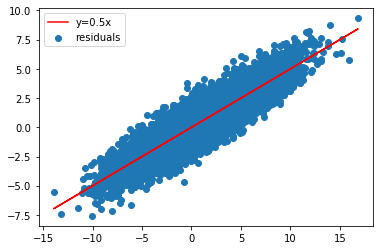

In [12]:
y = X[:,0]+np.random.normal(size=len(X))

y_hat = 0.5*X[:,0]

plt.scatter(X,y-y_hat,label = 'residuals')
plt.plot(X,0.5*X,color = 'red', label = 'y=0.5x')
plt.legend()
plt.show()